In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import glob as gb
import os
from scipy.optimize import curve_fit

%matplotlib inline
# %matplotlib qt

## Helper Functions

In [5]:
def mono_exp_decay(t, a, tau, c):
    """ Mono-exponential decay function. t is the time."""
    return a * np.exp(-t / tau) + c


def fit_decay(t, y):
    """ Function to fit the data, y, to the mono-exponential decay."""
    # Guess initial fitting parameters
    a_guess = max(y) - min(y)

    y_norm = y - min(y)
    y_norm = y_norm / max(y_norm)
    t_loc = np.where(y_norm <= 1/np.e)
    tau_guess = t[t_loc[0][0]]

    c_guess = min(y)
    # Fit decay
    popt, pcov = curve_fit(mono_exp_decay, t, y, p0=(a_guess, tau_guess, c_guess))
    return popt

# Analyse from CSV

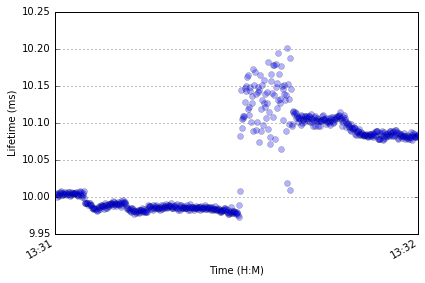

In [6]:
# Load CSV
df = pd.read_csv(os.path.join(dataFolder, measurement, 'analysis.csv'))

# Sort rows by datetime
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').sort_index()
df = df.reset_index()

fig, ax = plt.subplots()
ax.plot(df['datetime'], df['tau'], 'o', alpha=0.3)

# ax2 = ax.twinx()
# ax2.plot(df['datetime'], df['concentration'], 'r.')

# format the x ticks
ax.xaxis.set_major_locator(mdates.MinuteLocator(np.arange(0,60,10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=np.arange(0, 60, 10)))

ax.grid(True)
fig.autofmt_xdate()

plt.xlabel('Time (H:M)')
ax.set_ylabel('Lifetime (ms)')
# ax2.set_ylabel('Glucose concentration (mmol)')
plt.tight_layout()

# plt.savefig("Data/" + sample + '/conc_lifetimeVsTime.png', dpi=1000)

# Plot dataframe of h5 files (standard analysis)

In [38]:
def measurementAnalysis(dataFolder, chip, measurement):
    # List h5 sweep files
    sweepFiles = os.listdir(os.path.join(dataFolder, chip, measurement, "raw"))

    df = pd.DataFrame()
    for file in sweepFiles:
        file = os.path.join(dataFolder, chip, measurement, "raw", file)

        # Load HDF file
        store = pd.HDFStore(file)

        df_file = store['log']

        # Create time axis in ms
        fs = store['log']['fs'][0]
        samples = store['log']['sample_no'][0]

        x = np.arange(samples) * fs * 1E3

        # Load decay data
        y = store['data']

        # Calculate lifetime
        popt = fit_decay(x, y)
        tau = popt[1]

        # Append lifetime to dataframe
        df_file['a'] = popt[0]
        df_file['tau'] = popt[1]
        df_file['c'] = popt[2]

        # Add sweep data to measurement dataframe
        df = df.append(df_file)

        # Close hdf5 file
        store.close()
        
        # normalise y
        y -= min(y)
        y /= max(y)
        
        plt.ylim([0,1.1])
        plt.plot(x, y)
        i = df_file['sweep_no'][0]
        plt.savefig(dataFolder + '/plots/file%04d.png' % i, dpi=500)
        plt.clf()

    # Sort rows by datetime
    df = df.set_index('datetime').sort_index()
    df = df.reset_index()
    return df

In [39]:
dataFolder = "Misc"

# Get list of folders
samples = [f for f in os.listdir(dataFolder) if os.path.isdir(os.path.join(dataFolder, f))]

# Folder to analyse
measurement = samples[0]

In [40]:
chip = ''
df = measurementAnalysis(dataFolder, chip, measurement)

In [ ]:
df.head()

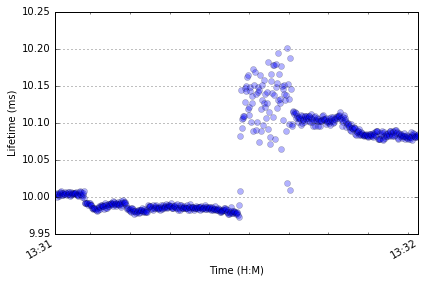

In [37]:
fig, ax = plt.subplots()
ax.plot(df['datetime'], df['tau'], 'o', alpha=0.3)

# ax2 = ax.twinx()
# ax2.plot(df['datetime'], df['concentration'], 'r.')

# format the x ticks
ax.xaxis.set_major_locator(mdates.MinuteLocator(np.arange(0,60,10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.SecondLocator(bysecond=np.arange(0, 60, 10)))

ax.grid(True)
fig.autofmt_xdate()

plt.xlabel('Time (H:M)')
ax.set_ylabel('Lifetime (ms)')
# ax2.set_ylabel('Glucose concentration (mmol)')
plt.tight_layout()

plt.savefig(dataFolder + '/plots/conc_lifetimeVsTime.png', dpi=1000)